EE488 HW #1: CIFAR-10 Classifier
====
TA : JongSuk Kim

TA's E-mail : jskpop@kaist.ac.kr

### ***Due Date: 3/20(Sun) 11:59 PM***

## Instruction
- In this HW, you will implement your own convolution neural network for classifying CIFAR-10 dataset

## Grading
- Total score is 10 points.

- You can get a base score by executing the code and submitting the output result in your ipynb file together. The base score is 6 points.

- Below is grading rule 
    - best_acc >= 80% : 10 
    - 70% <= best_acc < 80% : 9 
    - 60% <= best_acc < 70% : 8 points
    - 50% <= best_acc < 60% : 7 points
    - best_acc < 50% : 6 points

## Questions
- Please use QnA board in KLMS as a main communication channel. When you post questions, please make it public so that all students can share the information. Please use the prefix "[HW 1]" in the subject for all questions regarding this homework


### Import Library and Define Data Loader

CIFAR-10 is one of the most famous datasets for image classification. This dataset has 10 classes and each class includes 6,000 images, which size is 32×32. In each class, 5000 images are used for training and 1000 images are used for validation.

You can see more detail information about dataset in this [link](https://www.cs.toronto.edu/~kriz/cifar.html)

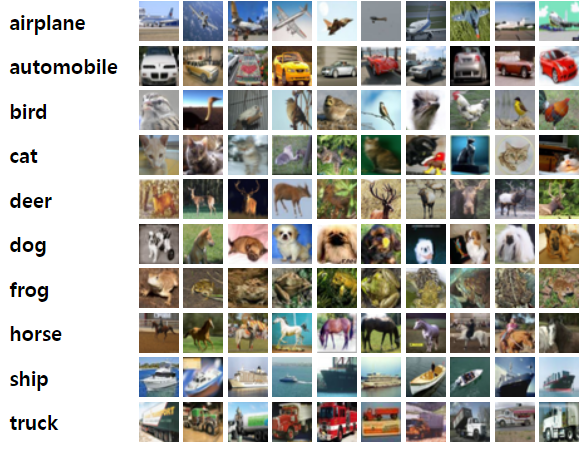

#### Import Library

In [ ]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import torchvision.datasets as vision_dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable 
from torch.utils import data
from PIL import Image

import random
random.seed(2022)
torch.manual_seed(2022)

#### Define DataLoader

torchvision datasets library already have method function for using CIFAR-10 dataset as MNIST dataset. 

Learn by changing various data augmentation to achieve high performance. Applicable augmentation can be referred to on this [page](https://pytorch.org/vision/master/transforms.html).

However, when validating, do not change the data aggregation option set by default below.(It is possible to adjust the image_size parameter to have the same image size in train and test time.)


In [ ]:
from torchvision.transforms.transforms import RandomHorizontalFlip
root='./data'
batch_size=32
image_size = 32
### You can delete or add any data augmentation in train_transform
train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
            transforms.ColorJitter(0.2, 0.2, 0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

cifar_train = vision_dsets.CIFAR10(root = root,  
                                train = True,  
                                transform = train_transform,
                                download = True) 

train_loader = data.DataLoader(dataset = cifar_train,  
                                    batch_size = batch_size, 
                                    shuffle =True, 
                                    num_workers = 2) 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# You should not change test transformation
test_transform = transforms.Compose([
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
cifar_test = vision_dsets.CIFAR10(root = root,
                                train = False, 
                                transform = test_transform,
                                download = True)
test_loader = data.DataLoader(dataset = cifar_test, 
                                batch_size = batch_size,
                                shuffle = False, 
                                num_workers = 2) 

Files already downloaded and verified


## Define Trainer

In [ ]:
class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):

        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion
        self.best_acc = 0
        
    def train(self, epoch = 1, log_freq = 500, test_on_train = False):
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0  
            for i, (inputs, labels) in enumerate(self.trainloader, 0): 
                inputs = inputs.cuda()
                labels = labels.cuda()
                self.optimizer.zero_grad()    

                outputs = self.net(inputs) 
                loss = self.criterion(outputs, labels) 
                loss.backward() 
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if (i+1) % log_freq == 0:   
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / log_freq))
                    running_loss = 0.0
            if test_on_train:
                self.test()
                print("best accuracy: {:.2f}%\n".format(self.best_acc))
                self.net.train()
        print('Finished Training')
        
    def test(self):
        self.net.eval() 

        test_loss = 0
        correct = 0
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda() 
            output = self.net(inputs) 
            pred = output.max(1, keepdim=True)[1] 
            correct += pred.eq(labels.view_as(pred)).sum().item()

            test_loss /= len(self.testloader.dataset)
        acc = 100.* correct / len(self.testloader.dataset)
        print('\nTest set:  Accuracy: {}/{} ({:.2f}%)'.
                format(correct, len(self.testloader.dataset),
                acc))
        if self.best_acc < acc:
            self.best_acc = acc

#### Define Network

Use Convolution Neural Network([docs](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) for training CIFAR-10 classifier.

You can change network architecture and use any other optimizer, learning rate, loss function.

In [ ]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [ ]:
class CIFARNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(8*8*128, 1024)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 10)



    def forward(self, x):
        # convolution layer
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)

        # fc layer
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
cifar_net = CIFARNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar_net.parameters(), lr=0.001) 

In [ ]:
trainer = Trainer(trainloader = train_loader,
                  testloader = test_loader,
                  net = cifar_net,
                  criterion = criterion,
                  optimizer = optimizer)

#### ***Notes*** (submission rule)
- Maximum traning epoch is 50.

- Do not erase the output when submitting the assignment.

- We will check the results one more time directly after submitting the assignment, but we strongly recommend not to erase them for reference.

- If there is no output result and the baseline code is submitted as it is, it is zero point.

In [17]:
trainer.train(epoch = 30, test_on_train = True)
trainer.test()

[1,   500] loss: 1.917
[1,  1000] loss: 1.594
[1,  1500] loss: 1.470

Test set:  Accuracy: 5267/10000 (52.67%)
best accuracy: 52.67%

[2,   500] loss: 1.367
[2,  1000] loss: 1.278
[2,  1500] loss: 1.220

Test set:  Accuracy: 6342/10000 (63.42%)
best accuracy: 63.42%

[3,   500] loss: 1.170
[3,  1000] loss: 1.114
[3,  1500] loss: 1.073

Test set:  Accuracy: 6633/10000 (66.33%)
best accuracy: 66.33%

[4,   500] loss: 1.041
[4,  1000] loss: 1.021
[4,  1500] loss: 0.994

Test set:  Accuracy: 7106/10000 (71.06%)
best accuracy: 71.06%

[5,   500] loss: 0.962
[5,  1000] loss: 0.957
[5,  1500] loss: 0.932

Test set:  Accuracy: 7189/10000 (71.89%)
best accuracy: 71.89%

[6,   500] loss: 0.897
[6,  1000] loss: 0.897
[6,  1500] loss: 0.895

Test set:  Accuracy: 7395/10000 (73.95%)
best accuracy: 73.95%

[7,   500] loss: 0.860
[7,  1000] loss: 0.874
[7,  1500] loss: 0.849

Test set:  Accuracy: 7571/10000 (75.71%)
best accuracy: 75.71%

[8,   500] loss: 0.834
[8,  1000] loss: 0.836
[8,  1500] loss: